In [3]:
import torch.nn.functional as F
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision
import pandas as pd
torch.manual_seed(0)

import glob
import random
import os
from torch.utils.data import Dataset
from PIL import Image

from skimage import color
import numpy as np
plt.rcParams["figure.figsize"] = (10, 10)

from utils import *
from generator import *
from loss import *
from block import *
from FID import *


/Users/namotaku/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/namotaku/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Hyper parameters


In [4]:
adv_criterion = nn.MSELoss() 
recon_criterion = nn.L1Loss() 

n_epochs = 100
dim_A = 3
dim_B = 3
display_step = 200
batch_size = 1
lr = 0.0002
load_shape = 286
target_shape = 256
device = 'mps'
hidden_dim = 64
expand_ratio = 4

data_path = "Monet2Photo"

pretrained = False
save_model = False

version = 'v1'

loss_path = f'{version}_loss.csv'
weights_path = f'cycleGAN_{version}_100000.pth'

# Training

  0%|          | 0/1072 [00:00<?, ?it/s]

/Users/namotaku/miniconda3/envs/torch/lib/python3.9/site-packages/torch/autograd/__init__.py:197: UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1672474101433/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0: Step 0: Generator (U-Net) loss: 0.06281894683837891, Discriminator loss: 0.0023123779892921447
FID A: 45.961783879519544 | FID B: 51.67925418725057 | Average FID: 48.820519033385054


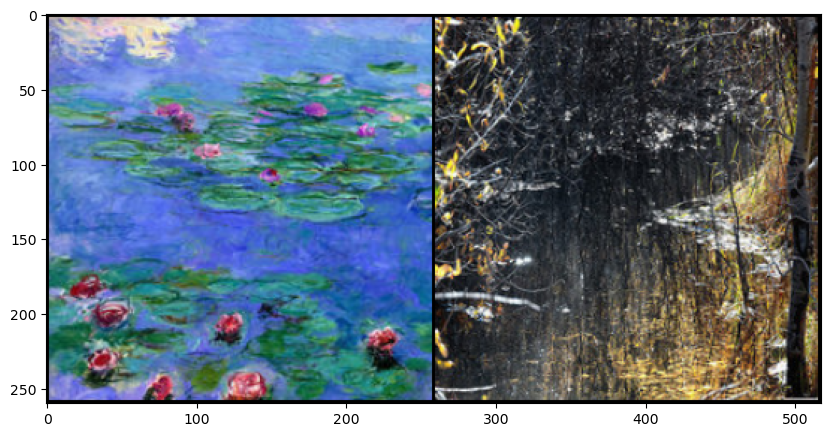

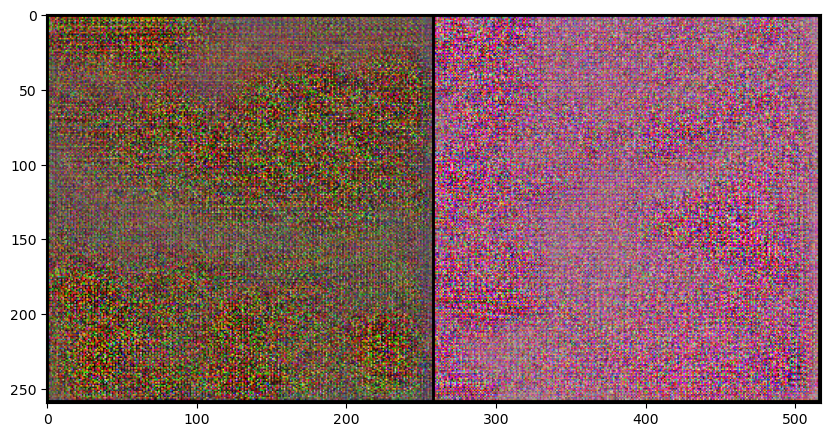

KeyboardInterrupt: 

In [5]:

if version == 'v0': block = ResnetBlock
if version == 'v1': block = InvertedBlock
if version == 'v2': block = ResidualBlock


# Transform
transform = transforms.Compose([
    transforms.Resize(load_shape),
    transforms.RandomCrop(target_shape),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

dataset = ImageDataset(data_path, transform=transform)

#Initialize
gen_AB = Generator(dim_A, dim_B, block, hidden_dim, expand_ratio).to(device)
gen_BA = Generator(dim_B, dim_A, block, hidden_dim, expand_ratio).to(device)
gen_opt = torch.optim.Adam(list(gen_AB.parameters()) + list(gen_BA.parameters()), lr=lr, betas=(0.5, 0.999))
disc_A = Discriminator(dim_A).to(device)
disc_A_opt = torch.optim.Adam(disc_A.parameters(), lr=lr, betas=(0.5, 0.999))
disc_B = Discriminator(dim_B).to(device)
disc_B_opt = torch.optim.Adam(disc_B.parameters(), lr=lr, betas=(0.5, 0.999))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

# load model
if pretrained:
    pre_dict = torch.load(weights_path)
    gen_AB.load_state_dict(pre_dict['gen_AB'])
    gen_BA.load_state_dict(pre_dict['gen_BA'])
    gen_opt.load_state_dict(pre_dict['gen_opt'])
    disc_A.load_state_dict(pre_dict['disc_A'])
    disc_A_opt.load_state_dict(pre_dict['disc_A_opt'])
    disc_B.load_state_dict(pre_dict['disc_B'])
    disc_B_opt.load_state_dict(pre_dict['disc_B_opt'])
    generator_loss, discriminator_loss, step = pd.read_csv(loss_path).values.tolist()
    cur_step = int(step[0])
else:
    gen_AB = gen_AB.apply(weights_init)
    gen_BA = gen_BA.apply(weights_init)
    disc_A = disc_A.apply(weights_init)
    disc_B = disc_B.apply(weights_init)
    generator_loss = []
    discriminator_loss = []
    cur_step = 0
    

def train(save_model=save_model, cur_step=cur_step):
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(n_epochs):
        # Dataloader returns the batches
        # for image, _ in tqdm(dataloader):
        for real_A, real_B in tqdm(dataloader):
            # image_width = image.shape[3]
            real_A = nn.functional.interpolate(real_A, size=target_shape)
            real_B = nn.functional.interpolate(real_B, size=target_shape)
            cur_batch_size = len(real_A)
            real_A = real_A.to(device)
            real_B = real_B.to(device)

            ### Update discriminator A ###
            disc_A_opt.zero_grad() # Zero out the gradient before backpropagation
            with torch.no_grad():
                fake_A = gen_BA(real_B)
            disc_A_loss = get_disc_loss(real_A, fake_A, disc_A, adv_criterion)
            disc_A_loss.backward(retain_graph=True) # Update gradients
            disc_A_opt.step() # Update optimizer

            ### Update discriminator B ###
            disc_B_opt.zero_grad() # Zero out the gradient before backpropagation
            with torch.no_grad():
                fake_B = gen_AB(real_A)
            disc_B_loss = get_disc_loss(real_B, fake_B, disc_B, adv_criterion)
            disc_B_loss.backward(retain_graph=True) # Update gradients
            disc_B_opt.step() # Update optimizer

            ### Update generator ###
            gen_opt.zero_grad()
            gen_loss, fake_A, fake_B = get_gen_loss(
                real_A, real_B, gen_AB, gen_BA, disc_A, disc_B, adv_criterion, recon_criterion, recon_criterion
            )
            gen_loss.backward() # Update gradients
            gen_opt.step() # Update optimizer

            # Keep track of the average discriminator loss
            mean_discriminator_loss += disc_A_loss.item() / display_step
            # Keep track of the average generator loss
            mean_generator_loss += gen_loss.item() / display_step

            ####################
            # COMPUT FID SCORE #
            ####################
            
            fid_score_A = calculate_fid_score(real_A, fake_B, inception_v3_model, device, batch_size=batch_size)
            fid_score_B = calculate_fid_score(real_B, fake_A, inception_v3_model, device, batch_size=batch_size)
            fid_score = (fid_score_A + fid_score_B) / 2


            ### Visualization code ###
            if cur_step % display_step == 0:
                print(f"Epoch {epoch}: Step {cur_step}: Generator (U-Net) loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}")
                print(f"FID A: {fid_score_A} | FID B: {fid_score_B} | Average FID: {fid_score}")
                show_tensor_images(torch.cat([real_A, real_B]), size=(dim_A, target_shape, target_shape))
                show_tensor_images(torch.cat([fake_B, fake_A]), size=(dim_B, target_shape, target_shape))
                generator_loss.append(mean_generator_loss)
                discriminator_loss.append(mean_discriminator_loss)
                mean_generator_loss = 0
                mean_discriminator_loss = 0

                if save_model:
                    torch.save({
                        'gen_AB': gen_AB.state_dict(),
                        'gen_BA': gen_BA.state_dict(),
                        'gen_opt': gen_opt.state_dict(),
                        'disc_A': disc_A.state_dict(),
                        'disc_A_opt': disc_A_opt.state_dict(),
                        'disc_B': disc_B.state_dict(),
                        'disc_B_opt': disc_B_opt.state_dict()
                    }, f"cycleGAN_{version}_{cur_step}.pth")

                    df = pd.DataFrame([generator_loss, discriminator_loss,[cur_step]]) 
                    df.to_csv(loss_path, index=False)
            cur_step += 1
train()